# Reinforcement Learning
_Oriol Bustos - May 2025_

## Imports

In [1]:
# # %pip install pip install box2d-py
# # %pip install --upgrade numpy
# %pip install gymnasium[box2d]

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math

# ────────────────────────────────────────────────────────────────────────────────
# 1.  ACTOR–CRITIC NETWORK  (256-256 hidden, tanh-squashed Gaussian policy)
# ────────────────────────────────────────────────────────────────────────────────
LOG_STD_MIN, LOG_STD_MAX = -5, 2            # keep std in a reasonable range

class ActorCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU()
        )
        self.policy_mean   = nn.Linear(256, action_dim)
        self.policy_logstd = nn.Linear(256, action_dim)
        self.value_head    = nn.Linear(256, 1)

    def forward(self, state_tensor):
        features = self.shared(state_tensor)
        mean = self.policy_mean(features)
        log_std = torch.clamp(self.policy_logstd(features), LOG_STD_MIN, LOG_STD_MAX)
        state_value = self.value_head(features).squeeze(-1)
        return mean, log_std, state_value

    # ——— helper to go from pre-tanh action u → squashed action a and its log-prob
    def _squash(self, mean, log_std, deterministic=False):
        std   = log_std.exp()
        if deterministic:
            u = mean
        else:
            u = mean + std * torch.randn_like(mean)
        a = torch.tanh(u)
        # log-prob with tanh correction term
        log_prob = (-0.5 * (((u - mean) / std).pow(2) + 2*log_std + math.log(2*math.pi))).sum(-1)
        log_prob -= (2*(math.log(2) - u - F.softplus(-2*u))).sum(-1)
        return a, u, log_prob

    @torch.no_grad()
    def get_action(self, state_tensor):
        mean, log_std, value_estimate = self(state_tensor)
        action, pre_tanh, log_prob = self._squash(mean, log_std, deterministic=False)
        return action, pre_tanh, log_prob, value_estimate

    def evaluate_actions(self, state_tensor, pre_tanh_tensor):
        mean, log_std, value_estimate = self(state_tensor)
        std   = log_std.exp()
        # Gaussian log prob BEFORE tanh
        log_prob = (-0.5 * (((pre_tanh_tensor - mean) / std).pow(2) + 2*log_std + math.log(2*math.pi))).sum(-1)
        # tanh correction
        log_prob -= (2*(math.log(2) - pre_tanh_tensor - F.softplus(-2*pre_tanh_tensor))).sum(-1)
        entropy = (0.5 + 0.5*math.log(2*math.pi) + log_std).sum(-1)  # entropy of Gaussian
        return log_prob, value_estimate, entropy


In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# 2.  ENV + PPO SET-UP  (unchanged variable names except made them explicit)
# ────────────────────────────────────────────────────────────────────────────────
env = gym.make("LunarLanderContinuous-v2")           # ← render_mode="human" if you want live view
state_dimension  = env.observation_space.shape[0]
action_dimension = env.action_space.shape[0]

agent = ActorCritic(state_dimension, action_dimension)
optimizer = optim.Adam(agent.parameters(), lr=3e-4)

# PPO / GAE hyperparameters (same spirit, just rolled-out longer)
GAMMA  = 0.99
LAMBDA = 0.95
CLIP_EPSILON = 0.2

ROLLOUT_LENGTH       = 2048   # collect this many time-steps before every update
MINI_BATCH_SIZE      = 256
PPO_EPOCHS_PER_BATCH = 10

ENTROPY_COEF = 0.0
VALUE_LOSS_COEF = 0.5

episode_returns = []
total_timesteps = 0
episode_counter = 0

# ─── compatibility with Gym >=0.26 / Gymnasium ────────────────────────
def reset_env(env):
    out = env.reset()
    return out[0] if isinstance(out, tuple) else out

def step_env(env, action):
    out = env.step(action)
    if len(out) == 5:        # new API: (obs, reward, terminated, truncated, info)
        obs, reward, terminated, truncated, info = out
        done = terminated or truncated
        return obs, reward, done, info
    else:                    # old API: (obs, reward, done, info)
        return out
# ─────────────────────────────────────────────────────────────────────


In [11]:
# ────────────────────────────────────────────────────────────────────────────────
# 3.  TRAINING LOOP  (same logic, now rolls out until 2048 steps are gathered)
# ────────────────────────────────────────────────────────────────────────────────
while total_timesteps < 2_000_000:  # ≈1 h on CPU — stop whenever you like
    # storage for one PPO batch
    batch_states, batch_pre_tanh, batch_actions = [], [], []
    batch_log_probs_old, batch_values, batch_rewards, batch_dones = [], [], [], []

    steps_in_batch = 0
    while steps_in_batch < ROLLOUT_LENGTH:
        current_state = reset_env(env)
        done = False
        episode_return = 0.0
        while not done:
            state_tensor = torch.as_tensor(current_state, dtype=torch.float32).unsqueeze(0)
            action, pre_tanh, log_prob, value_estimate = agent.get_action(state_tensor)

            # store transition
            batch_states.append(current_state)
            batch_pre_tanh.append(pre_tanh.squeeze(0).cpu().numpy())
            batch_actions.append(action.squeeze(0).cpu().numpy())
            batch_log_probs_old.append(log_prob.item())
            batch_values.append(value_estimate.item())

            next_state, reward, done, _ = step_env(env, action.squeeze(0).cpu().numpy())
            batch_rewards.append(reward)
            batch_dones.append(done)
            episode_return += reward
            steps_in_batch += 1
            total_timesteps += 1

            current_state = next_state
            if steps_in_batch == ROLLOUT_LENGTH:
                # break out of episode early to respect batch size
                break

        episode_returns.append(episode_return)
        episode_counter += 1
        if episode_counter % 10 == 0:
            last_10_avg = np.mean(episode_returns[-10:])
            print(f"Episode {episode_counter:4d}, "
                  f"Reward {episode_return:8.2f}, "
                  f"Last-10 avg {last_10_avg:8.2f}")

    # -------  compute GAE advantages  -------
    states_tensor      = torch.as_tensor(np.array(batch_states),       dtype=torch.float32)
    pre_tanh_tensor    = torch.as_tensor(np.array(batch_pre_tanh),     dtype=torch.float32)
    actions_tensor     = torch.as_tensor(np.array(batch_actions),      dtype=torch.float32)
    log_probs_old_t    = torch.as_tensor(np.array(batch_log_probs_old),dtype=torch.float32)
    values_tensor      = torch.as_tensor(np.array(batch_values + [0]), dtype=torch.float32)  # pad for next_value
    rewards_np         = np.array(batch_rewards)
    dones_np           = np.array(batch_dones)

    # bootstrap with zero at batch end (episodic)
    advantages = np.zeros_like(rewards_np)
    gae = 0.0
    for t in reversed(range(len(rewards_np))):
        mask = 1.0 - dones_np[t]
        delta = rewards_np[t] + GAMMA * values_tensor[t+1] * mask - values_tensor[t]
        gae = delta + GAMMA * LAMBDA * mask * gae
        advantages[t] = gae
    returns_np = advantages + values_tensor[:-1].numpy()

    advantages_tensor = torch.as_tensor(advantages, dtype=torch.float32)
    returns_tensor    = torch.as_tensor(returns_np,  dtype=torch.float32)

    advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

    # -------  PPO update  -------
    num_samples = states_tensor.size(0)
    for epoch in range(PPO_EPOCHS_PER_BATCH):
        indices = np.random.permutation(num_samples)
        for start in range(0, num_samples, MINI_BATCH_SIZE):
            end = start + MINI_BATCH_SIZE
            batch_idx = indices[start:end]

            logp_new, values_new, entropy = agent.evaluate_actions(
                states_tensor[batch_idx], pre_tanh_tensor[batch_idx])

            ratio = torch.exp(logp_new - log_probs_old_t[batch_idx])
            surr1 = ratio * advantages_tensor[batch_idx]
            surr2 = torch.clamp(ratio, 1.0 - CLIP_EPSILON, 1.0 + CLIP_EPSILON) * advantages_tensor[batch_idx]
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = VALUE_LOSS_COEF * (returns_tensor[batch_idx] - values_new).pow(2).mean()
            entropy_loss = -ENTROPY_COEF * entropy.mean()
            total_loss = policy_loss + value_loss + entropy_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    # optional: stop early if we are consistently above 200
    if len(episode_returns) >= 100 and np.mean(episode_returns[-100:]) >= 200:
        print("Environment solved!")
        break

env.close()


c:\Users\oriol\miniconda3\envs\gan_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode   10, Reward  -117.89, Last-10 avg  -182.83
Episode   20, Reward   -25.48, Last-10 avg  -278.08
Episode   30, Reward   -58.86, Last-10 avg  -164.11
Episode   40, Reward  -528.35, Last-10 avg  -227.15
Episode   50, Reward  -183.69, Last-10 avg  -220.06
Episode   60, Reward   -96.02, Last-10 avg  -243.67
Episode   70, Reward  -180.89, Last-10 avg  -159.57
Episode   80, Reward   -67.82, Last-10 avg  -246.21
Episode   90, Reward   -89.55, Last-10 avg  -164.73
Episode  100, Reward  -219.63, Last-10 avg  -218.76
Episode  110, Reward  -117.37, Last-10 avg  -235.30
Episode  120, Reward   -87.54, Last-10 avg  -116.80
Episode  130, Reward   -57.57, Last-10 avg  -134.22
Episode  140, Reward  -157.36, Last-10 avg  -183.07
Episode  150, Reward   -61.52, Last-10 avg  -135.02
Episode  160, Reward  -117.34, Last-10 avg  -183.51
Episode  170, Reward    26.71, Last-10 avg  -142.94
Episode  180, Reward   -47.38, Last-10 avg  -133.61
Episode  190, Reward  -242.14, Last-10 avg  -180.33
Episode  200

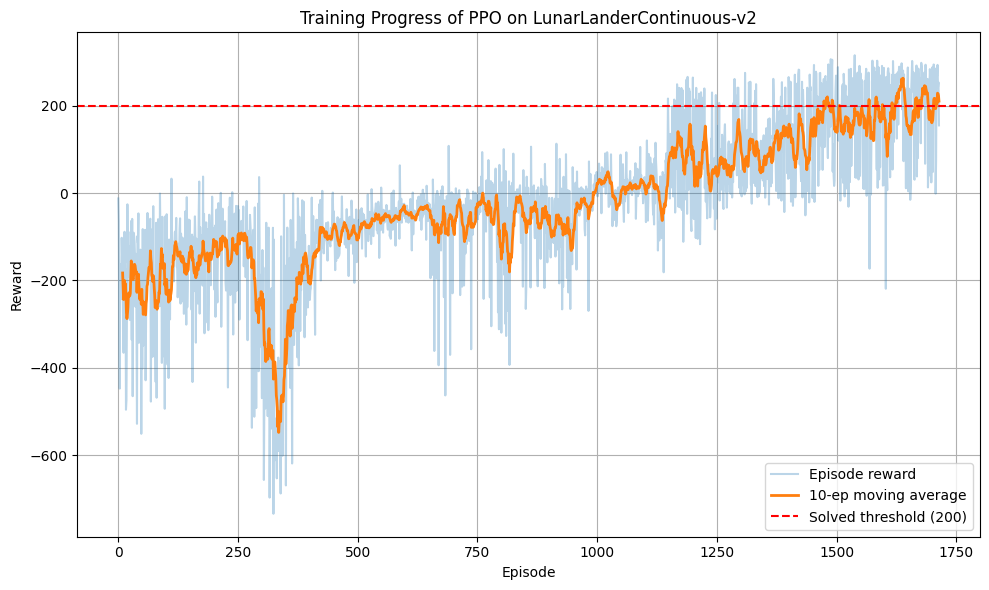

In [13]:
# Compute moving average (e.g. 10-episode window)
def moving_avg(x, window=10):
    return np.convolve(x, np.ones(window)/window, mode='valid')

rewards = np.array(episode_returns)
avg_rewards = moving_avg(rewards)

plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Episode reward', alpha=0.3)
plt.plot(np.arange(len(avg_rewards)) + 10 - 1, avg_rewards, label='10-ep moving average', linewidth=2)
plt.axhline(200, color='red', linestyle='--', label='Solved threshold (200)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Progress of PPO on LunarLanderContinuous-v2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:

# Initialize the environment and the trained PPO agent (assuming it's already trained)
env = gym.make("LunarLanderContinuous-v2", render_mode="human")  # For Gym >= 0.26 or Gymnasium
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Assuming the existing ActorCritic class and the agent have been defined and trained
state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()

for _ in range(1000):
    env.render()
    
    state_t = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action, pre_tanh, log_prob, value_estimate = agent.get_action(state_t)
        # if you don’t care about the extras you can also write:
        # action, _, _, _ = agent.get_action(state_t)

    # now step the env exactly as before
    next_step = env.step(action.numpy()[0])
    state = next_step[0] if len(next_step) == 5 else next_step[0]
    done  = next_step[2] if len(next_step) == 5 else next_step[2]

    if done:
        state = env.reset()[0] if isinstance(env.reset(), tuple) else env.reset()

env.close()

KeyboardInterrupt: 